# A Bag Of Tricks for Preventing Overfitting

## Review

1. What are:
 * underfitting: MSSE on loss stays high, potential causes: when your model hasn't trained from long enough, activation function isn't complex enough to model data, might not have enough data, data is pathalogical(i.e. didn't normalize/something went bad(labels are off)) --- easy to see but hard to diagnose
 * overfitting: when model didn't learn to generalize, loss function gets low but evaluation metric gets high. Potential causes include: memorizing(storinging data in database), way you split the ata, too complicatied of an architecture.
2. How can you detect them?

Some important notes from the reading for today, plus one of my own:
* Many deep learning models are *overparametrized*.
* This means that they "are typically expressive enough to perfectly fit every training example, even in datasets consisting of millions" of data points.
* "Even stranger ... we can actually reduce the generalization error further by making the model even more expressive, e.g., adding layers, nodes, or training for a larger number of epochs." 
* "The pattern relating the generalization gap to the complexity of the model ... can be non-monotonic, with greater complexity hurting at first but subsequently helping". 
* "The guarantees provided by classical learning theory ... appear powerless to explain why it is that deep neural networks generalize in the first place." 

## Trick 1: Regularization

Let me show you what Bing beta said about L1 and L2 regularization!

Okay, let's define L1 and L2 regularization:
* L1: $\frac{1}{N} \sum_{i=1}^N (y-\hat{y})^2 + \lambda \sum_{i=1}^N |w_i|$
* L2: $\frac{1}{N} \sum_{i=1}^N (y-\hat{y})^2 + \lambda \sum_{i=1}^N w_i^2$

where $\lambda$ is a weight for the strength of the regularization.

Notes:
* L1 regularization "zeros out" less significant features, so it performs feature selection
* L1 regularization gives a sparse solution
* L2 regularization is more computationally efficient
* L1 regularization is robust to outliers
* *Lasso regression* is linear regression with L1 regularization
* "Ridge regression" is linear regression with L2 regularization

Additional reading:
* https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization
* https://scikit-learn.org/stable/modules/linear_model.html
* https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regularization

The first term of both L1 and L2 normalization is the MSE.

## Trick 2: Dropout

Dropout "injects" noise by randomly dropping out (zeroing out) some of the nodes in each hidden layer at each round of training.

Looking at the code in the book:

Pick randome nodes to drop from the system in the hidden layer, which helps small networks not overfit

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # this would drop out every node in this layer
    if dropout == 1: 
        return torch.zeros_like(X)
    # this drops out some nodes at random
    mask = (torch.rand(X.shape) > dropout).float()
   
    return mask * X / (1.0 - dropout)

In [3]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        # exercises for the curious:
        #  (1) what is the architecture of this network?
        #  (2) what is the computation graph of this network?
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        # we drop out different nodes at random during each round of training, but never during evaluation or inference
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

KeyboardInterrupt: 

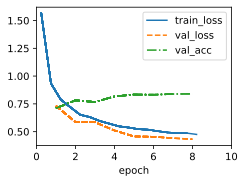

In [5]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.625, 'dropout_2':0.625, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Trick 3: Early Stopping

So far, when we've said "early stopping" we've meant "stop when the loss mostly stops changing". Now we will talk about why this works, beyond the efficiency argument.

When there is **label noise**, a neural network will fit clean data *first*. How do you know if there is label noise?
* There may often naturally be label noise
  * You could check if the same data point appears twice in the data with different labels
  * You could look at any annotations on the data and see if there was annotator disagreement
* It's also dead easy to *introduce* noise into the data

Let's take a look at this fascinating paper about early stopping: http://proceedings.mlr.press/v139/garg21a/garg21a.pdf

Why this works: Neural Networks will fit clean data before noisy data. 